In [1]:
#basic package
import json
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import shutil
import time
import datetime as dt
import itertools
import time
import re
from collections import Counter
from collections import defaultdict
import operator
import math
import functools
import collections
import random

#modelling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, cohen_kappa_score
from xgboost import plot_importance
#catboost, for a better support of categorical data
from catboost import CatBoostClassifier, Pool
#to use all except one core
import multiprocessing

#save models
import joblib

#plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import is_WG_open, ConfMat, list_of_zones, res_intodico
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


# Download Input Data

In [3]:
#define parameters
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
dico_matching = config.dico_matching
dico_garden_opening_hour = config.dico_garden_opening_hour
path_extracted_data_cleaning = os.path.join(path_extracted_data,'Cleaning')
path__ = os.path.join(path_extracted_data_cleaning,'1secTS')
#create a director if not existing
if not os.path.exists(path__):
    os.makedirs(path__)
path_extracted_data_cleaning_model = os.path.join(path_extracted_data_cleaning,'model') 
if not os.path.exists(path_extracted_data_cleaning_model):
    os.makedirs(path_extracted_data_cleaning_model)    
#feature for model
li_cont_select = config.li_cont_select
li_bin = config.li_bin
li_cat_select = config.li_cat_select

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
df = pd.read_csv(os.path.join(path_extracted_data_cleaning, id_run+'InputCleaning.csv'), parse_dates=['Timestamp', 'date'], 
                 dayfirst=True, sep=';')
df['VideoAnalyse'] = df['VideoAnalyse'].map(lambda x: int(x)) #not before as tehre was srting as well
df = df[df['VideoAnalyse'].isin([0,1])]
df = shuffle(df)
print(df.shape)
df.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(5137, 35)


,Timestamp,TagID,HenID,Trackingsystem_Zone,PenID,VideoAnalyse,system,date,type,signalstrength,...,previous_duration,algo_type,BatchID,previousZone==NextZone,next_duration,next2zone==Zone,previous2zone==Zone,zone3_match_exist,is_first_observation,Observed_Zone
463,2020-10-24 14:25:11,tag_42,hen_64,3_Zone,pen4,1,3 - 5,2020-10-24,students,8.0,...,321.0,cleaning,NaN,True,159.0,1.0,1.0,1.0,0.0,3_Zone
1989,2020-10-23 14:31:51,tag_62,hen_12,2_Zone,pen5,1,3 - 5,2020-10-23,students,16.0,...,93.0,verification,ID30,False,882.0,1.0,0.0,1.0,0.0,2_Zone
2882,2020-10-16 11:17:49,tag_107,hen_5,3_Zone,pen9,1,8 - 9,2020-10-16,students,15.0,...,1436.0,verification,ID11,True,1630.0,1.0,0.0,0.0,0.0,3_Zone


In [5]:
df['VideoAnalyse'].value_counts()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1    4559
0     578
Name: VideoAnalyse, dtype: int64

# Data preprocessing

In [6]:
#scaling numerical data: necessary due to duration high values
display(df[li_cont_select].head(3))
sc = StandardScaler()
li_scale = [x for x in li_cont_select if x not in li_bin]
df[li_scale] = sc.fit_transform(df[li_scale])
display(df[li_cont_select].head(3))

#display categoricalfeatures
df[li_cat_select].head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,signalstrength,signalstzone2,duration,next_duration,previous_duration,next2zone==Zone,previous2zone==Zone,zone3_match_exist
463,8.0,6.0,5.0,159.0,321.0,1.0,1.0,1.0
1989,16.0,10.0,105.0,882.0,93.0,1.0,0.0,1.0
2882,15.0,5.0,144.0,1630.0,1436.0,1.0,0.0,0.0


,signalstrength,signalstzone2,duration,next_duration,previous_duration,next2zone==Zone,previous2zone==Zone,zone3_match_exist
463,-0.902404,-0.482508,-0.055514,-0.039212,-0.017102,1.0,1.0,1.0
1989,1.082353,0.565766,-0.042772,0.052111,-0.032257,1.0,0.0,1.0
2882,0.834258,-0.744576,-0.037802,0.146593,0.057007,1.0,0.0,0.0


,Trackingsystem_Zone,zone2_match,previous1_zone,next1_zone,system
463,3_Zone,3_Zone,3_Zone,3_Zone,3 - 5
1989,2_Zone,3_Zone,3_Zone,1_Zone,3 - 5
2882,3_Zone,2_Zone,2_Zone,2_Zone,8 - 9


# Split into training and validation (for parameter tuning) & dummies

In [7]:
df_cleaning = df[df['algo_type']=='cleaning'].copy()
df_cleaning['VideoAnalyse'].value_counts()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1    3738
0     536
Name: VideoAnalyse, dtype: int64

In [8]:
#sklearn: RF and gradientboosting
####### train,test dummie #######
#transform categorical data into dumies
df_cl_d = pd.get_dummies(df_cleaning.filter(li_cont_select+li_cat_select, axis=1), columns=li_cat_select, drop_first=True)
    
#split into train, test and put into good format
#train
X_train = df_cl_d.values
y_train = df_cleaning[['VideoAnalyse']].values
y_train = np.ravel(y_train) #from (x,1) to (x,)
print(X_train.shape, y_train.shape)

#var name
var_name = df_cl_d.columns
#split into a validation dataset for first step of parameter tuning (narrow down without over-fitting)
val_size = 0.2; rs = 0
X_train_tuning, X_val_tuning, y_train_tuning, y_val_tuning = train_test_split(X_train, y_train, 
                                                                              test_size=val_size, random_state=rs)

#small control: show rows with at least one nan
if df_cl_d[df_cl_d.isna().any(axis=1)].shape[0]!=0:
    print('ERROR: you have nan in your cleaning set')
    sys.exit()

(4274, 27) (4274,)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Model

In [9]:
li_dico = []

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 1 - Random forest & GradientBoostingMachine

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

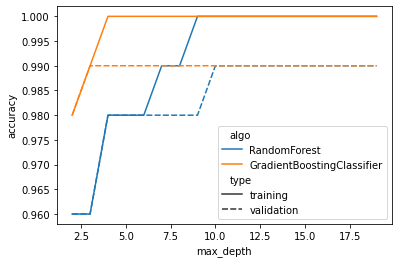

 20%|████████████████▊                                                                   | 1/5 [01:03<04:15, 63.90s/it]

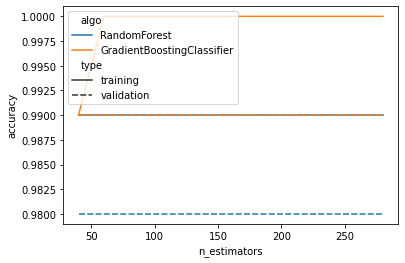

 40%|█████████████████████████████████▌                                                  | 2/5 [01:23<02:31, 50.55s/it]

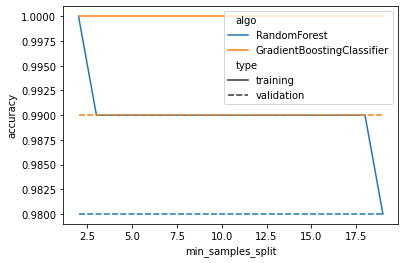

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:40<01:20, 40.40s/it]

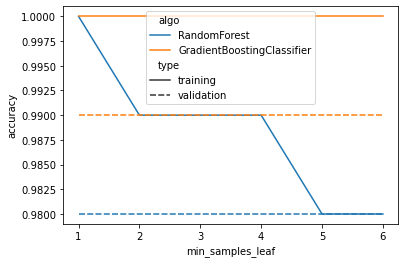

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:46<00:30, 30.14s/it]

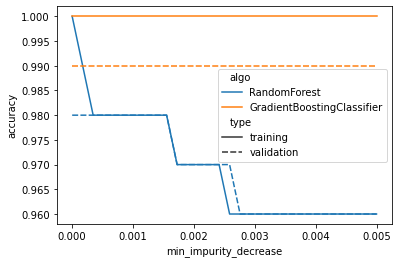

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.60s/it]


In [10]:
#FIRST: SEE WHICH RANGE FOR EACH PARAMETER AVOIDING OVERFITTING
li_plt = []
dico_hyperparam_values = {'max_depth': range(2,20),
                          'n_estimators': range(40,300,20),
                          'min_samples_split':range(2,20),
                          'min_samples_leaf':range(1,7),
                          'min_impurity_decrease':[x for x in np.linspace(start = 0, stop = 0.005, num = 30)]}

#lets fix maxdepth first and then keep rest default except max_features
for hp,li in tqdm.tqdm(dico_hyperparam_values.items()):
    for v in li:
        if hp=='max_depth':
            dico_mod = {'RandomForest':RandomForestClassifier(max_features='sqrt', random_state=rs,
                                                             max_depth=v),
                        'GradientBoostingClassifier': GradientBoostingClassifier(max_features='sqrt', random_state=rs,
                                                                                 max_depth=v)}
        if hp=='n_estimators':
            dico_mod = {'RandomForest':RandomForestClassifier(max_features='sqrt', random_state=rs,
                                                              max_depth = 9,                                                                                 min_samples_split=10,
                                                              n_estimators=v),
                        'GradientBoostingClassifier': GradientBoostingClassifier(max_features='sqrt', random_state=rs,
                                                                                 max_depth = 5, 
                                                                                 n_estimators=v)}
        if hp=='min_samples_split':
            dico_mod = {'RandomForest':RandomForestClassifier(max_features='sqrt', random_state=rs,
                                                              max_depth = 9, 
                                                              min_samples_split=v),
                        'GradientBoostingClassifier': GradientBoostingClassifier(max_features='sqrt', random_state=rs,
                                                                                 max_depth = 5,
                                                                                 min_samples_split=v)}
        if hp=='min_samples_leaf':
            dico_mod = {'RandomForest':RandomForestClassifier(max_features='sqrt', random_state=rs,
                                                              max_depth = 9, 
                                                              min_samples_leaf=v),
                        'GradientBoostingClassifier': GradientBoostingClassifier(max_features='sqrt', random_state=rs,
                                                                                 max_depth = 5, 
                                                                                 min_samples_leaf=v)}
        if hp=='min_impurity_decrease':
            dico_mod = {'RandomForest':RandomForestClassifier(max_features='sqrt', random_state=rs,
                                                              max_depth = 9, 
                                                              min_impurity_decrease=v),
                        'GradientBoostingClassifier': GradientBoostingClassifier(max_features='sqrt', random_state=rs,
                                                                                 max_depth = 5, 
                                                                                 min_impurity_decrease=v)}
        for name,mod in dico_mod.items():
            mod.fit(X_train_tuning, y_train_tuning)
            li_plt.append({'algo':name, hp:v, 'type':'training', 'accuracy':round(mod.score(X_train_tuning, y_train_tuning),2)})
            li_plt.append({'algo':name, hp:v, 'type':'validation', 'accuracy':round(mod.score(X_val_tuning, y_val_tuning),2)})
            #save it
            #predictor.score(X,Y) internally calculates Y'=predictor.predict(X) and then compares Y' against Y to give an accuracy
            #measure. This applies not only to logistic regression but to any other model.
            li_dico.append({'algo':name, 'model_param_used':mod,
                            'accuracy_training':round(mod.score(X_train_tuning, y_train_tuning),2),
                            'accuracy_validation':round(mod.score(X_val_tuning, y_val_tuning),2)})
    sns.lineplot(data=pd.DataFrame(li_plt), x=hp, y="accuracy", hue="algo", style="type");
    plt.savefig(os.path.join(path_extracted_data_cleaning,id_run+'_ClassifierParamTuning_'+hp+'.png'), bbox_inches='tight')
    plt.show()

### 1- Random Forest

In [11]:
#THEN: refine the parameters
x1 = df_cleaning[df_cleaning['VideoAnalyse']==1].shape[0]
x0 = df_cleaning[df_cleaning['VideoAnalyse']==0].shape[0]
print(x1/x0)
P = {'max_features': ['sqrt'], #nbr of features to consider when looking for the best split
      'criterion':['gini', 'entropy'],
      'max_depth': [13],
      'min_samples_leaf': [2,3],#min samples at a leaf node
      'min_samples_split':[2,3,4,5], #min nbr of samples required to split a node, we may want this to be bigger for RF (more complex trees)
      'n_estimators':[100,110,120],#nbr of trees in the forest default=100
      'min_impurity_decrease':[x for x in np.linspace(start = 0.000001, stop = 0.001, num = 10)],
      'bootstrap': [True],
      'class_weight': [{0:x1/x0, 1:1}]}
#define the model with all these options and fit it (as many combinationa s asked for)
mod = GridSearchCV(estimator = RandomForestClassifier(), param_grid = P, cv = 3, n_jobs = -1, verbose = 2) 
mod.fit(X_train, y_train)
#define the best model and fit it 
mod_final = mod.best_estimator_
mod_final.fit(X_train, y_train)
#save the trained classifier
joblib.dump(mod_final, os.path.join(path_extracted_data_cleaning_model, 'selected_randomforest.pkl') )
display(mod_final)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


6.973880597014926
Fitting 3 folds for each of 480 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  1.2min finished


RandomForestClassifier(class_weight={0: 6.973880597014926, 1: 1},
                       criterion='entropy', max_depth=13, max_features='sqrt',
                       min_impurity_decrease=0.0003340000000000001,
                       min_samples_leaf=3, min_samples_split=5,
                       n_estimators=120)

In [12]:
li_dico.append({'algo':'best-randomforest', 'model_param_used':mod_final, 
                'accuracy_training':round(mod_final.score(X_train, y_train),3)})
pd.DataFrame(li_dico)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,algo,model_param_used,accuracy_training,accuracy_validation
0,RandomForest,"(DecisionTreeClassifier(max_depth=2, max_featu...",0.960,0.96
1,GradientBoostingClassifier,([DecisionTreeRegressor(criterion='friedman_ms...,0.980,0.98
2,RandomForest,"(DecisionTreeClassifier(max_depth=3, max_featu...",0.960,0.96
3,GradientBoostingClassifier,([DecisionTreeRegressor(criterion='friedman_ms...,0.990,0.99
4,RandomForest,"(DecisionTreeClassifier(max_depth=4, max_featu...",0.980,0.98
...,...,...,...,...
166,RandomForest,"(DecisionTreeClassifier(max_depth=9, max_featu...",0.960,0.96
167,GradientBoostingClassifier,([DecisionTreeRegressor(criterion='friedman_ms...,1.000,0.99
168,RandomForest,"(DecisionTreeClassifier(max_depth=9, max_featu...",0.960,0.96
169,GradientBoostingClassifier,([DecisionTreeRegressor(criterion='friedman_ms...,1.000,0.99


### 2 - GradientBoostingClassifier

In [13]:
#THEN: refine the parameters
P = {'max_features': ['sqrt'],
     'n_estimators': [100], #the more trees you add, the higher the risk of overfitting!! default:100
     'min_samples_split':range(3,10),
     'min_samples_leaf':[4,5,6],
     'max_depth': [5,6], #if to big: risk of overfitting default=3, should be smaller than RF, trees here should be simpler
     'min_impurity_decrease':[x for x in np.linspace(start = 0.00001, stop = 0.001, num = 5)],
     'learning_rate':[0.1,0.15],
     'loss':['deviance'], #deviance is gradiant boosting
     'criterion':['friedman_mse','mse','mae'],
     'validation_fraction':[val_size], #to have early stopping avoiding overfitting keep same as for catboost
     'n_iter_no_change':range(3,10),#to have early stopping avoiding overfitting. If set to a number, it will set aside validation_fraction size of the training data as validation and terminate training when validation score is not improving in all of the previous n_iter_no_change numbers of iterations.
     'tol':[0.001]#to have early stopping avoiding overfitting. default 1e-4 
    }
mod = GridSearchCV(estimator = GradientBoostingClassifier(), param_grid=P, cv=3, n_jobs=-1, verbose=2) 
mod.fit(X_train, y_train)
mod_final = mod.best_estimator_
mod_final.fit(X_train, y_train)
# save the trained classifier
joblib.dump(mod_final, os.path.join(path_extracted_data_cleaning_model, 'selected_GBC.pkl') )
display(mod_final)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 8820 candidates, totalling 26460 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   51.0s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 5112 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 6490 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 8028 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 9730 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 11592 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 13618 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 15804 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 17933 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 19188 tasks      | elapsed

GradientBoostingClassifier(learning_rate=0.15, max_depth=6, max_features='sqrt',
                           min_impurity_decrease=0.0002575, min_samples_leaf=4,
                           min_samples_split=7, n_iter_no_change=8, tol=0.001,
                           validation_fraction=0.2)

In [14]:
li_dico.append({'algo':'best-GradientBoostingClassifier', 'model_param_used':mod_final, 
                'accuracy_training':round(mod_final.score(X_train, y_train),3)})
pd.DataFrame(li_dico)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,algo,model_param_used,accuracy_training,accuracy_validation
0,RandomForest,"(DecisionTreeClassifier(max_depth=2, max_featu...",0.960,0.96
1,GradientBoostingClassifier,([DecisionTreeRegressor(criterion='friedman_ms...,0.980,0.98
2,RandomForest,"(DecisionTreeClassifier(max_depth=3, max_featu...",0.960,0.96
3,GradientBoostingClassifier,([DecisionTreeRegressor(criterion='friedman_ms...,0.990,0.99
4,RandomForest,"(DecisionTreeClassifier(max_depth=4, max_featu...",0.980,0.98
...,...,...,...,...
167,GradientBoostingClassifier,([DecisionTreeRegressor(criterion='friedman_ms...,1.000,0.99
168,RandomForest,"(DecisionTreeClassifier(max_depth=9, max_featu...",0.960,0.96
169,GradientBoostingClassifier,([DecisionTreeRegressor(criterion='friedman_ms...,1.000,0.99
170,best-randomforest,"(DecisionTreeClassifier(criterion='entropy', m...",0.994,NaN


# save final results

In [15]:
df_res = pd.DataFrame(li_dico)
print(df_res.shape)
df_res.to_csv(os.path.join(path_extracted_data_cleaning, 'RF&GB_finetuning.csv'), sep=';', index=False)      

(172, 4)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
